# ERA5 to monthly climatologies of Tmin and Tmax
This scripts reads the MERRA2 files and generates the monthly climaoltogical files of Tmin and Tmax to be read by LDT.
Improvements for the future:
* Add an option to do it for local time. Follow UTC rules from LIS. For now, the full MERRA2 file is read (UTC0). Note that this will be hard since two files will need to be openned.
* ERA5 could be added

In [5]:
import numpy as np
import xarray as xr
import glob, os
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import re
import pandas as pd

### Prep environment

In [6]:
# start and end to compte clim
ystart = 2005
yend = 2024 # this year is included
years = np.arange(ystart,yend+1)

# directories
mapping_file = '/staging/leuven/stg_00024/input/met_forcing/ERA5/meta/era5_mapping.nc'
l_files = []
for y in years:
    l_files.extend(sorted(glob.glob(f'/staging/leuven/stg_00024/input/met_forcing/ERA5/FORCING_{y}*.nc')))
print(len(l_files))
output_dir = f'/staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_{ystart}-{yend}'

240


In [7]:
ds_map = xr.open_dataset(mapping_file)
ds_forcing = xr.open_dataset(l_files[0])

# Extract the land index grid from era5_mapping.nc
land_mask = ds_map['G2P'].values

# Extract the forcing data (time x land_points)
forcing_data = ds_forcing['Tair'].values  # Shape: (745, 340819)

# Extract time dimension from FORCING.nc
time = ds_forcing['time'].values

# Define grid size
n_time = forcing_data.shape[0]
n_lat, n_lon = land_mask.shape

# Get land locations (non-zero values)
land_indices = land_mask > 0  # Boolean mask for land
land_positions = np.where(land_indices)  # Tuple of (lat_idx, lon_idx)
land_values = land_mask[land_indices] - 1  # Convert 1-based to 0-based indices

# Initialize the 3D array with NaNs (for water areas)
forcing_3d = np.full((n_time, n_lat, n_lon), np.nan)

lat = np.linspace(-90, 89.75, n_lat)
lon = np.linspace(-180, 179.75, n_lon)

# Fill land cells using NumPy indexing
forcing_3d[:, land_positions[0], land_positions[1]] = forcing_data[:, land_values]

# open example file for dims
dims = (12, forcing_3d.shape[1],forcing_3d.shape[2])
print(dims)

ds_map.close()
ds_forcing.close()
del forcing_data, forcing_3d, ds_map, ds_forcing

(12, 720, 1440)


### Compute clim

In [8]:
# loop over years, it will take some time
Tmin_months = np.zeros(dims)
Tmax_months = np.zeros(dims)

for f, file in tqdm(enumerate(l_files), total=len(l_files)):
    # Regular expression pattern to extract the year and the month after "FORCING_"
    match = re.search(r'FORCING_(\d{4})(\d{2})', l_files[f])
    year = int(match.group(1))  # Extracted year
    month = int(match.group(2))
    start_date = pd.to_datetime(f"{year}-{month}-01")

    ds = xr.open_dataset(l_files[f])

    # Extract the forcing data (time x land_points)
    forcing_data = ds['Tair'].values  # Shape: (745, 340819)

    # Extract time dimension from FORCING.nc
    time = ds['time'].values
    ds.close()

    # Initialize the 3D array with NaNs (for water areas)
    forcing_3d = np.full((forcing_data.shape[0], n_lat, n_lon), np.nan) #time, lat, lon

    # Fill land cells using NumPy indexing
    forcing_3d[:, land_positions[0], land_positions[1]] = forcing_data[:, land_values]
    Tair_3d = xr.DataArray(forcing_3d, coords=[('time', time), ('lat', lat), ('lon', lon)])

    # Create a datetime index corresponding to each hour in the month
    time_dates = pd.to_datetime(start_date) + pd.to_timedelta(time, unit='h')

    # Add the time as a new coordinate to the dataset
    Tair_3d.coords['time'] = ('time', time_dates)

    # Group by day and calculate the daily minimum for each grid cell
    daily_data = Tair_3d.groupby("time.day")

    Tmin_months[month-1,:,:] += daily_data.min(dim="time", skipna=True).mean(dim="day", skipna=True)
    Tmax_months[month-1,:,:] += daily_data.max(dim="time", skipna=True).mean(dim="day", skipna=True)

for m in np.arange(12):
    Tmin_months[m,:,:] = Tmin_months[m,:,:]/len(years)
    Tmax_months[m,:,:] = Tmax_months[m,:,:]/len(years)
        
        

100%|██████████| 240/240 [54:59<00:00, 13.75s/it]  


### Verification
Next cell visualizes the results as maps and time series. The user can change the month, row, col to make sure everything looks alright.

45.0 8.0


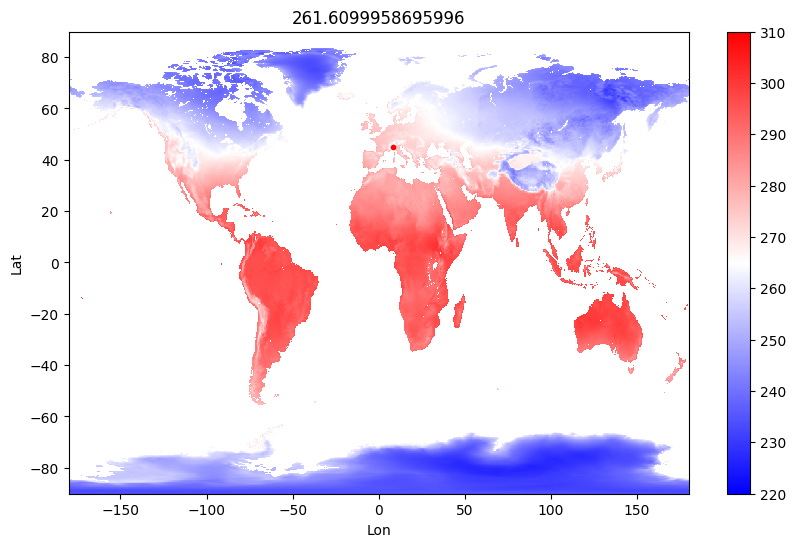

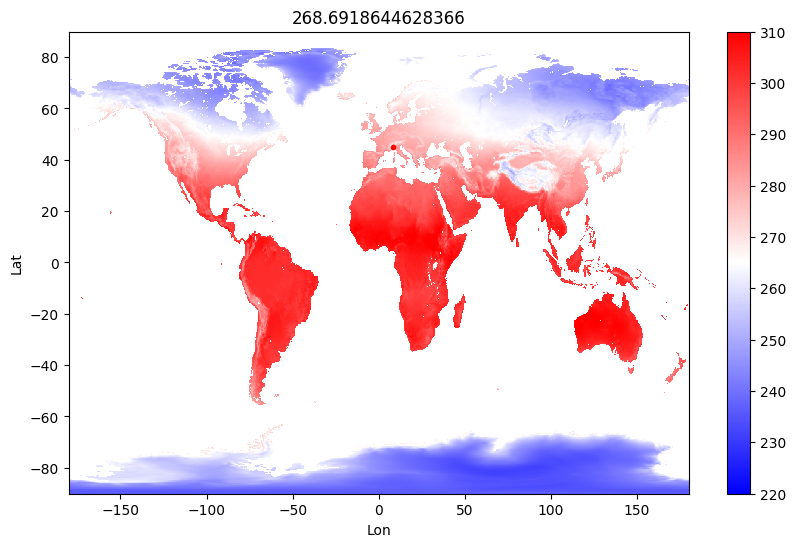

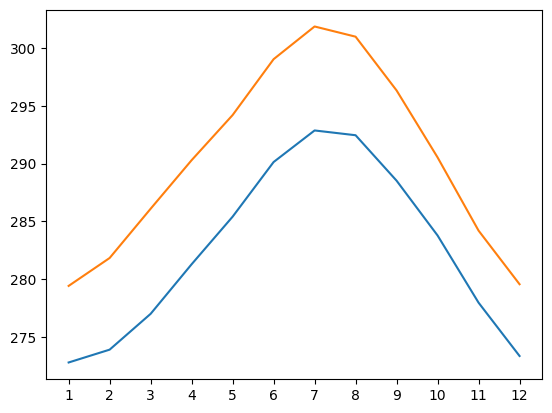

In [9]:
row = 540
col = 752
month_sel = 1
# Example lat, lon, and 2D data arrays
print(float(lat[row]), float(lon[col]))

# Create a meshgrid for lat and lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Plotting the 2D array with pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon_grid, lat_grid, Tmin_months[month_sel,:,:], vmin=220, vmax=310, cmap='bwr', shading='auto')
plt.plot(lon[col], lat[row], marker='.', color='r', linestyle="None")
plt.colorbar()
plt.title(str(np.nanmean(Tmin_months[month_sel,:,:])))
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

# Plotting the 2D array with pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon_grid, lat_grid, Tmax_months[month_sel,:,:], vmin=220, vmax=310, cmap='bwr', shading='auto')
plt.plot(lon[col], lat[row], marker='.', color='r', linestyle="None")
plt.colorbar()
plt.title(str(np.nanmean(Tmax_months[month_sel,:,:])))
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()

plt.plot(Tmin_months[:,row,col])
plt.plot(Tmax_months[:,row,col])
plt.xticks(ticks=range(12), labels=[str(m+1) for m in range(12)])
plt.show()

### Save in LIS format
This cell saves the climatologies in monthly text files, as read in by LDT.

In [10]:
# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Month names for the file names
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Set the grid size and parameters
ncols = int(lon.size)
nrows = int(lat.size)
cellxsize = round(float(lon[1]-lon[0]), 3)
cellysize = round(float(lat[1]-lat[0]), 3)
xllcorner = lon[0] + 0.5 * cellxsize
yllcorner = lat[0] + 0.5 * cellysize
NODATA_value = -9999

Tmin_months = np.nan_to_num(Tmin_months, nan=NODATA_value)
Tmax_months = np.nan_to_num(Tmax_months, nan=NODATA_value)

# Save data to text files
for i, month in enumerate(month_names):
    # Create file names
    tmin_file = os.path.join(output_dir, f'tmin.{month}.txt')
    tmax_file = os.path.join(output_dir, f'tmax.{month}.txt')
    
    # Write tmin data
    with open(tmin_file, 'w') as f:
        f.write(f"ncols {ncols}\n")
        f.write(f"nrows {nrows}\n")
        f.write(f"xllcorner {xllcorner}\n")
        f.write(f"yllcorner {yllcorner}\n")
        f.write(f"cellxsize {cellxsize}\n")
        f.write(f"cellysize {cellysize}\n")
        f.write(f"NODATA_value {NODATA_value}\n")
        
        # Write each column in a new line
        for j in range(nrows):
            f.write(' '.join(f'{Tmin_months[i, j, k]:.4f}' for k in range(ncols)) + '\n')

    # Write tmax data
    with open(tmax_file, 'w') as f:
        f.write(f"ncols {ncols}\n")
        f.write(f"nrows {nrows}\n")
        f.write(f"xllcorner {xllcorner}\n")
        f.write(f"yllcorner {yllcorner}\n")
        f.write(f"cellxsize {cellxsize}\n")
        f.write(f"cellysize {cellysize}\n")
        f.write(f"NODATA_value {NODATA_value}\n")
        
        # Write each column in a new line
        for j in range(nrows):
            f.write(' '.join(f'{Tmax_months[i, j, k]:.4f}' for k in range(ncols)) + '\n')
    
    print(f'Saved: {tmin_file}')
    print(f'Saved: {tmax_file}')

print('All monthly text files have been saved.')

Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmin.jan.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmax.jan.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmin.feb.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmax.feb.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmin.mar.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmax.mar.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmin.apr.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmax.apr.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmin.may.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmax.may.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/ERA5_2005-2024/tmin.jun.txt
Saved: /staging/leuve